In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
import fastai
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "../../data_segments/data_balanced_duplicate_sample/"
sz=256
arch=resnet50

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['models', 'valid', 'train']

In [7]:
files = os.listdir(f'{PATH}valid/Celiac')[:5]
files

['C16-77_02_3330_999_1.jpg',
 'C06-27_02_5994_4662_0.jpg',
 'C06-28_02_13653_666_1.jpg',
 'C06-28_02_13320_1332_1.jpg',
 'C06-32_02_5994_2664_0.jpg']

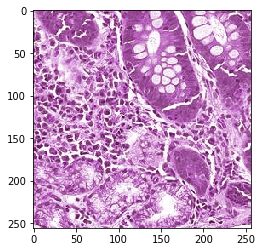

In [8]:
img = plt.imread(f'{PATH}valid/Celiac/{files[4]}')
plt.imshow(img);

In [9]:
arch=resnet50
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 2475/2475 [13:48<00:00,  3.94it/s]  


In [15]:
learn.fit(0.001, 2)

epoch      trn_loss   val_loss   accuracy                        
    0      0.443531   0.49896    0.782074  
    1      0.406466   0.477206   0.794474                        



[0.4772062137856943, 0.7944741893120517]

## Visualising Results

In [ ]:
# This is the label for a val data
data.val_y

In [ ]:
# from here we know that 'Celiac' is label 0 and 'EE' is label 1 and 'Normal' is label 2
data.classes

In [ ]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

In [ ]:
imr = ImageModelResults(data.val_ds, log_preds)
print('Most Correct Celiac')
imr.plot_most_correct(0)

In [ ]:
print('Most Correct EE')
imr.plot_most_correct(1)

In [ ]:
print('Most Correct Normal')
imr.plot_most_correct(2)

In [ ]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

In [ ]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

In [ ]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:
y = data.val_y

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

## Finding a optimum learning rate

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot()

## Data Augmentation

In [10]:
# Using predefined augmentations transforms_top_down
tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

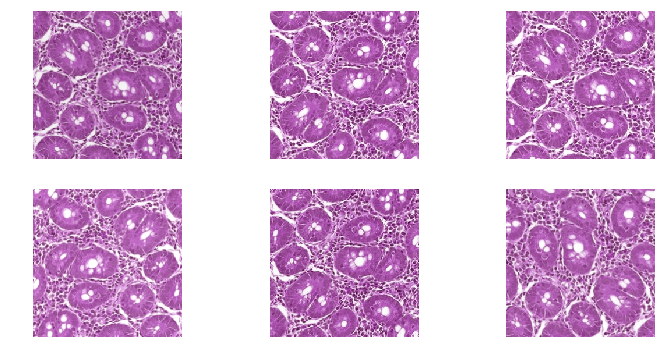

In [11]:
# Visualising the augmentation
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [12]:
# Initializing the data with augmentation and learn method
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.precompute = False

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(1e-3, 3, cycle_len=1)

In [ ]:
learn.save('256_lastlayer_resnet50_duplicates_staintools')

In [ ]:
learn.load('256_lastlayer_resnet50_duplicates_staintools')

## Unfreezing layers and using Differential learning rates

In [13]:
# Unfreeze all layers for training
learn.unfreeze()

In [23]:
lrf=learn.lr_find()

 70%|███████   | 5139/7308 [46:52<19:08,  1.89it/s, loss=1.05]   

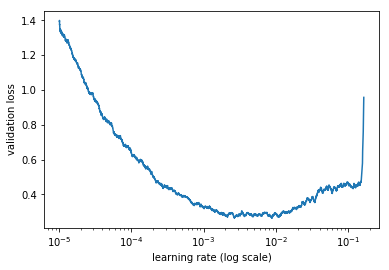

In [24]:
learn.sched.plot()

In [25]:
lr = (1e-4 + 1e-3)/2

In [26]:
lr=np.array([lr/9,lr/3,lr])

In [27]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                        
    0      0.282904   0.293136   0.867146  
    1      0.189414   0.250551   0.890816                        
    2      0.176108   0.237044   0.898001                        
    3      0.149503   0.232792   0.903475                        
    4      0.107044   0.252353   0.902219                        
    5      0.095916   0.254349   0.902869                         
    6      0.103324   0.236783   0.908899                      96]


[0.2367826086762626, 0.9088986261358935]

In [30]:
learn.save('256_all_resnet50_duplicates_staintools')

In [14]:
learn.load('256_all_resnet50_duplicates_staintools')

## Analyzing results

### Confusion Matrix and Accuracy with Test Time Augmentation

In [ ]:
# Getting log predictions with TTA
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

In [ ]:
log_preds.shape

In [ ]:
log_preds_mean = np.mean(log_preds, 0)

In [ ]:
np.save('../data_segments/logpreds_resnet50_all_layers256x256_duplicates_TTA_staintools.npy', log_preds)

In [ ]:
preds = np.argmax(probs, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

### Visualizing results with TTA

In [ ]:
imr = ImageModelResults(data.val_ds, log_preds_mean)
print('Most Correct Celiac')
imr.plot_most_correct(0)

In [ ]:
print('Most Correct EE')
imr.plot_most_correct(1)

In [ ]:
print('Most Correct Noraml')
imr.plot_most_correct(2)

In [ ]:
print('Most Incorrect Celiac')
imr.plot_most_incorrect(0)

In [ ]:
print('Most Incorrect EE')
imr.plot_most_incorrect(1)

In [ ]:
print('Most Incorrect Normal')
imr.plot_most_incorrect(2)

In [ ]:
print('Most Uncertain Celiac')
imr.plot_most_uncertain(0)

In [ ]:
print('Most Uncertain EE')
imr.plot_most_uncertain(1)

In [ ]:
print('Most Uncertain Normal')
imr.plot_most_uncertain(2)

### Confusion Matrix and Accuracy without Test Time Augmentation

In [ ]:
# Getting log predictions without TTA
log_preds = learn.predict()

In [ ]:
preds = np.argmax(log_preds, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

## Saving predictions of the model with TTA

In [ ]:
res = pd.DataFrame(np.exp(log_preds_mean))

In [ ]:
res['file'] = data.val_ds.fnames

In [ ]:
res.columns = ['Celiac', 'EE', 'Normal', 'FileName']

In [ ]:
res.to_csv('../results/preds_resnet50_256_duplicates_TTA_staintools.csv')

In [ ]:
res.head()

In [ ]:
res.to_csv('../results/preds_resnet50_256_duplicates_TTA_HSV_contrast.csv')